In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F 

import utils.tavr_torch as tavr_torch
from utils.tavr_torch import TAVR_3_Frame, TAVR_1_Frame, TAVR_Sequence, tavr_dataloader
from utils.visualization import display_grid, z_stretch, visualize_frame, set_figsize, get_central_slices
from utils.loss_functions import batch_l2_loss
from utils.run_model import train, test, save, load, get_loss_history
from Models.basic_models import average_model, two_layer_basic, post_process, two_d_basic

set_figsize(20, 15)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
USE_GPU = False
dtype = torch.float32 # we will be using float throughout this tutorial
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('using device:', device)

# "Pixl", "Slice", or "None"
preproc_type = "pixel"

validation = TAVR_3_Frame("__valid", preproc=preproc_type)
val_loader = tavr_dataloader(validation, batch_size=4, shuffle=True, num_workers=2)
training = TAVR_3_Frame("__train", preproc=preproc_type)
train_loader = tavr_dataloader(training,batch_size=8, shuffle=True, num_workers=2)


ave_model = average_model()
model = two_d_basic()
post_proc = post_process(kind=preproc_type).to(device=device)
loss_fn = batch_l2_loss()

# CHANGE TO NAME OF JUPYTER NOTEBOOK
model_name = "Model 6 (2d CNN+PixelNorm-Adam) Run 1"

using device: cpu


In [5]:
learning_rate = 3e-3
momentum = 0.90
reg = 1e-7

optimizer = optim.Adam(model.parameters())

In [9]:
# Run cell to load model
LOAD = True
iteration_num = 81

if LOAD:
    
    load(model_name, iteration_num, model, optimizer)
    loss_history = get_loss_history(model_name)
    model.to(device=device)
else:
    loss_history = None

model loaded from model_checkpoints/Model 6 (2d CNN+PixelNorm-Adam) Run 1/Model 6 (2d CNN+PixelNorm-Adam) Run 1-81


In [10]:
train(model, post_proc, optimizer, train_loader, val_loader, loss_fn, device, 
         model_name, loss_history, epochs=3, print_every=30, print_level=4, lr_decay=1)

... 0.3184... 0.2967... 0.3200
Iteration 90, loss = 0.2957, corrected loss = 137.5924
Validation loss 134.2636 over 81 frames
model saved to model_checkpoints/Model 6 (2d CNN+PixelNorm-Adam) Run 1/Model 6 (2d CNN+PixelNorm-Adam) Run 1-90
conv_a1.weight,   	norm: 4.7381e+00, 	update norm: 3.0216e-03 	Update/norm: 6.3773e-04
conv_a1.bias,   	norm: 6.2940e-01, 	update norm: 1.7762e-03 	Update/norm: 2.8221e-03
conv_b1.weight,   	norm: 3.6298e+00, 	update norm: 2.4998e-03 	Update/norm: 6.8868e-04
conv_b1.bias,   	norm: 6.2394e-01, 	update norm: 7.7933e-04 	Update/norm: 1.2490e-03
final.weight,   	norm: 1.5565e+00, 	update norm: 1.8016e-03 	Update/norm: 1.1574e-03
final.bias,   	norm: 2.9988e-01, 	update norm: 7.8082e-05 	Update/norm: 2.6038e-04

... 0.3007... 0.3167... 0.3129
Iter 100... 0.3052... 0.2858... 0.2914
Iter 110... 0.2944... 0.2673... 0.2776
Iteration 120, loss = 0.2809, corrected loss = 130.7282
Validation loss 118.2089 over 81 frames
model saved to model_checkpoints/Model 6 (2d

Training directory found, 36 series
Validation directory found, 6 series
Testing directory found, 10 series
Validation loss 36.7888 over 81 frames
Validation loss 66.8315 over 81 frames
torch.Size([1, 77, 256, 256])
torch.Size([1, 77, 256, 256])
torch.Size([1, 77, 256, 256])
torch.Size([1, 77, 256, 256])
torch.Size([77, 256, 256])
torch.Size([77, 256, 256])
torch.Size([77, 256, 256])
torch.Size([77, 256, 256])
torch.Size([77, 256, 256])
torch.Size([77, 256, 256])
torch.Size([77, 256, 256])
torch.Size([77, 256, 256])
torch.Size([77, 256, 256])
torch.Size([77, 256, 256])


/home/shared/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


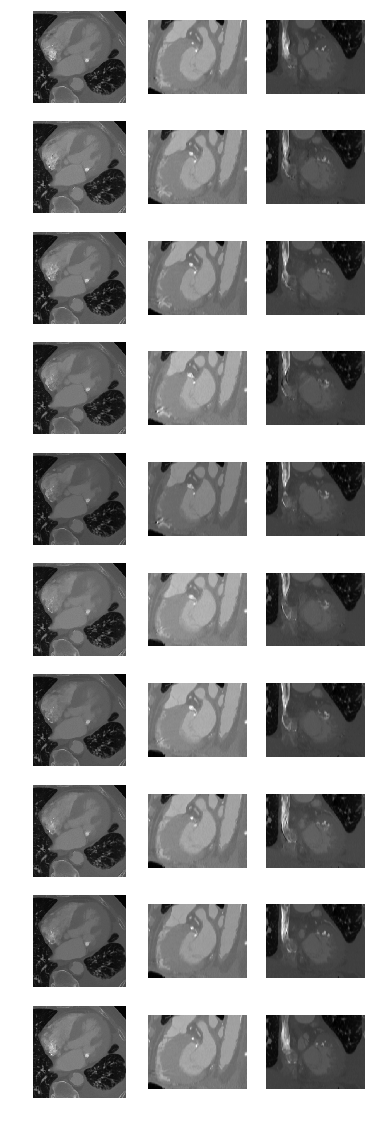

In [11]:
# One last test + visualize results on 1 validation sequence
val_seq = TAVR_Sequence("__valid")
test(ave_model, post_proc, val_loader, loss_fn, device)
test(model, post_proc, val_loader, loss_fn, device)

with torch.no_grad():
    model.eval()
    ave_frames = [post_proc(val_seq[0][0])]
    for i in range(2,9,2):
        ave_frame = model((val_seq[0][i-2][None,:], val_seq[0][i][None,:]))
        print(ave_frame.shape)
        ave_frames += [post_proc(ave_frame[0]),  post_proc(val_seq[0][i])]
    ave_frames += [post_proc(val_seq[0][9])]
    ave_frames_slices = []
    for f in ave_frames:
        print(f.shape)
        ave_frames_slices += get_central_slices(f)
    set_figsize(6,20)
    display_grid(10, 3, ave_frames_slices)

In [12]:
optimizer.param_groups[0]['lr']

0.001

In [13]:
for p in model.parameters():
    print(p.norm())

tensor(4.7082)
tensor(0.7410)
tensor(3.6314)
tensor(0.6008)
tensor(1.5263)
tensor(0.2498)
